In [13]:
%cd /scratch/bruingjde/SNAM2021-code/

from constants import *

/scratch/bruingjde/SNAM2021-code


# Size

In [14]:
size = tlp.ProgressParallel(n_jobs=network_count, total=network_count)(
  joblib.delayed(get_size)(network_index) for network_index in network_indices
)
  
size = pd.DataFrame(size)
size

  0%|          | 0/26 [00:00<?, ?it/s]

,nodes,edges,events
1,1824701,8344615,29487744
2,16959,1194440,2322259
3,87273,299220,1148072
4,55387,335708,335708
5,17218,55276,88090
6,6798,214693,290597
7,855165,3358827,23787273
8,55387,335708,335708
9,30398,86312,87627
10,279374,1546540,1729983


# Other stats

In [3]:
stats = get_all_stats(network_indices=network_indices) 
stats = stats[['density', 'degree assortativity', 'average clustering coefficient']]
stats

  0%|          | 0/26 [00:00<?, ?it/s]

,density,degree assortativity,average clustering coefficient
1,0.000005,0.114186,0.632629
2,0.008307,0.059906,0.606845
3,0.000079,-0.166689,0.119342
4,0.000219,0.221522,0.123693
5,0.000373,0.177355,0.642282
6,0.009293,0.010808,0.770476
7,0.000009,0.155727,0.606712
8,0.000219,0.221522,0.123693
9,0.000187,0.008341,0.005286
10,0.000040,-0.055707,0.089571


# Diameter

In [4]:
diameter = get_diameter()
diameter

  0%|          | 0/26 [00:00<?, ?it/s]

{1: 23,
 2: 8,
 3: 14,
 4: 16,
 5: 19,
 6: 11,
 7: 22,
 8: 16,
 9: 12,
 10: 18,
 11: 4,
 12: 5,
 13: 6,
 14: 9,
 16: 14,
 18: 10,
 19: 8,
 20: 14,
 21: 13,
 22: 13,
 23: 12,
 24: 8,
 25: 10,
 28: 11,
 29: 17,
 30: 7}

# Static features

In [8]:
def logistic_regression_I(network_index: int):
  X = dict()
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = np.load(
      f'data/{network_index:02}/features/time_agnostic/{heuristic}.npy')
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network_index:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000)) # type: ignore
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1]) # type: ignore
  
  return auc

auc_I = {
  network_index: logistic_regression_I(network_index) 
  for network_index in network_indices}
auc_I

{1: 0.699924097961159,
 2: 0.8143284728472847,
 3: 0.8613062444958731,
 4: 0.7506946672481443,
 5: 0.6925966656698206,
 6: 0.7533923284953032,
 7: 0.7163399049436928,
 8: 0.7546202156938044,
 9: 0.8405976473095821,
 10: 0.8921576425730398,
 11: 0.9362951126582724,
 12: 0.8586906690669067,
 13: 0.738536525733494,
 14: 0.867469046358269,
 16: 0.8848937918118533,
 18: 0.8608546145337374,
 19: 0.9151420838625097,
 20: 0.8319948714428556,
 21: 0.6868458781362007,
 22: 0.9413970629070905,
 23: 0.9268580332817813,
 24: 0.7816485573922645,
 25: 0.8643604442037945,
 28: 0.8791134475241598,
 29: 0.904999392764926,
 30: 0.8318958379300065}

# Node temporal features

In [6]:
def logistic_regression_I_II(network_index: int, hypergraph: bool):
  X = dict()
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = (
      np.load(
        f'data/{network_index:02}/features/time_agnostic/{heuristic}.npy'))
    
  if hypergraph:
    for time_strategy in time_strategies:
      for nodepair_strategy in nodepair_strategies:
        for aggregation_strategy in ['m0', 'm1', 'm2', 'm3', 'q0', 'q25', 'q50', 'q75', 'q100']:
          X[(time_strategy, nodepair_strategy, aggregation_strategy)] = (
            np.load(
              f'data/{network_index:02}/features/time_node/'
              f'{time_strategy}_{nodepair_strategy}_{aggregation_strategy}.npy'
            ))
  else:
    for time_strategy in time_strategies:
      for nodepair_strategy in nodepair_strategies:
          X[(time_strategy, nodepair_strategy)] = (
            np.load(
              f'data/{network_index:02}/features/time_node/'
              f'{time_strategy}_{nodepair_strategy}.npy'))
    
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network_index:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

auc_I_II = {
  network_index: (
    logistic_regression_I_II(
      network_index, hypergraph=network_index in hypergraph_indices
    )
  )
  for network_index in network_indices
}
auc_I_II

{1: 0.7920932310346859,
 2: 0.8680074699887106,
 3: 0.910095344807511,
 4: 0.7846909963985594,
 5: 0.7191603912866438,
 6: 0.8210045385914684,
 7: 0.8281480948094808,
 8: 0.7695917356355753,
 9: 0.8730075199999999,
 10: 0.92104130867474,
 11: 0.9332287752639995,
 12: 0.9035033445605352,
 13: 0.8718804757531987,
 14: 0.9316179049418367,
 16: 0.9416733560096325,
 18: 0.9397506419773478,
 19: 0.9394996460718456,
 20: 0.9401433691756272,
 21: 0.7170140588889977,
 22: 0.9722219199930368,
 23: 0.963841165526021,
 24: 0.9486037989470483,
 25: 0.9394734854691053,
 28: 0.8841493232016263,
 29: 0.9216305208892848,
 30: 0.8484279014904563}

# Edge temporal features

In [7]:
def logistic_regression_III(network_index: int, hypergraph: bool):
  X = dict()
  
  for heuristic in ['aa', 'cn', 'jc', 'pa']:  
    for time_strategy in time_strategies:
      if hypergraph:
        for aggregation_strategy in ['m0', 'm1', 'q0', 'q25', 'q50', 'q75', 'q100']:
            X[(heuristic, time_strategy, aggregation_strategy)] = np.load(
                f'data/{network_index:02}/features/time_edge/'
                f'{heuristic}_{time_strategy}_{aggregation_strategy}.npy')
      else:
        X[(heuristic, time_strategy)] = np.load(
          f'data/{network_index:02}/features/time_edge/'
          f'{heuristic}_{time_strategy}.npy')
    
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network_index:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

auc_III = {
  network_index: logistic_regression_III(
    network_index, hypergraph=network_index in hypergraph_indices)
  for network_index in network_indices}
auc_III

{1: 0.8146751489979615,
 2: 0.8525497239898362,
 3: 0.8784198080177978,
 4: 0.7859246302488722,
 5: 0.7517025529614252,
 6: 0.8023390248238554,
 7: 0.8409793952582293,
 8: 0.7982422832268523,
 9: 0.8485403048435456,
 10: 0.9249837262482051,
 11: 0.94023448,
 12: 0.8960919393098151,
 13: 0.793380326512631,
 14: 0.9248861508750631,
 16: 0.9302565365469929,
 18: 0.9275861180012487,
 19: 0.9234620715281183,
 20: 0.9299367878269322,
 21: 0.7176814703667035,
 22: 0.9590662901712841,
 23: 0.9522892870610273,
 24: 0.8872790307272169,
 25: 0.9070825515272039,
 28: 0.8945673300923651,
 29: 0.9162775456705169,
 30: 0.8524738493322173}

# Figures

In [18]:
df = pd.concat([
  size,
  stats,
  pd.Series(diameter, name='diameter'),
  pd.Series(auc_I, name='time agnostic'),
#   pd.Series(auc_I_II, name='I+II'),
  pd.Series(auc_III, name='time aware')
], axis=1)
df.columns

Index(['nodes', 'edges', 'events', 'density', 'degree assortativity',
       'average clustering coefficient', 'diameter', 'time agnostic',
       'time aware'],
      dtype='object')

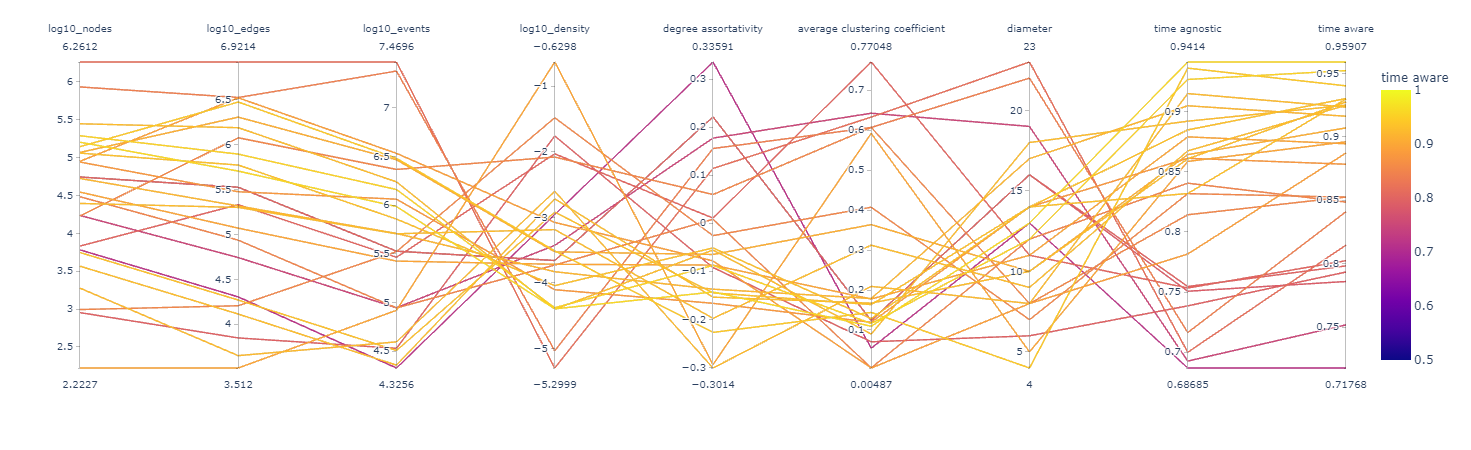

In [33]:
import plotly.express as px
fig = px.parallel_coordinates(
  df.assign(log10_nodes=np.log10(df['nodes']), 
            log10_edges=np.log10(df['edges']),
            log10_events=np.log10(df['events']),
            log10_density=np.log10(df['density'])), 
  ['log10_nodes', 'log10_edges', 'log10_events', 'log10_density', 
   'degree assortativity', 
   'average clustering coefficient', 'diameter', 'time agnostic', 
   'time aware'], 
  color='time aware',
  range_color=(.5,1))
fig

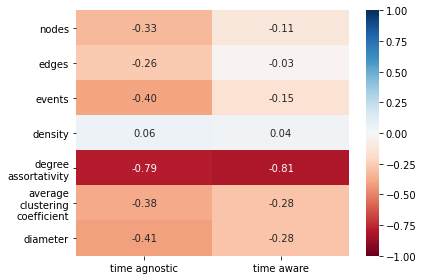

In [41]:
sns.heatmap(
  (
    df.corr()
    .loc[['time agnostic', 'time aware']]
    .T
    .drop(index=['time aware', 'time agnostic'])
    .rename({
      'average clustering coefficient': 'average\nclustering\ncoefficient',
      'degree assortativity': 'degree\nassortativity'})
  ), vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='RdBu')
plt.yticks(rotation=0) 
plt.tight_layout()
plt.savefig('figures/heatmap.pdf')

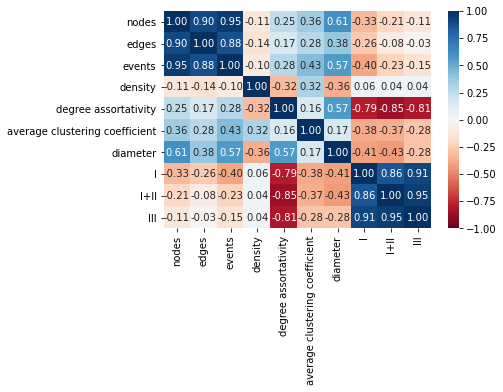

In [12]:
df = pd.concat([
  size,
  stats,
  pd.Series(diameter, name='diameter'),
  pd.Series(auc_I, name='I'),
  pd.Series(auc_I_II, name='I+II'),
  pd.Series(auc_III, name='III')
], axis=1)

sns.heatmap(
  df.corr(),
  vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='RdBu')
plt.yticks(rotation=0) 
plt.savefig('figures/heatmap.pdf')